In [135]:
# minor annoyance that I still don't get
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.calibration import CalibrationDisplay
import xgboost as xgb

from ift6758.pipeline import ExperimentPipeline, DEFAULT_TRANSFORMATIONS
from importlib import reload 
import ift6758.pipeline

In [136]:
reload(ift6758.pipeline.features)

from ift6758.pipeline.features import (
    mirror_coordinates,
    append_shot_angle,
    append_shot_distance,
    replace_nan_by_0,
    append_game_secs,
    append_time_lapse_prev,
    append_dist_prev,
    append_rebound,
    append_angle_change,
    append_speed
)

In [137]:
trans = [
    mirror_coordinates,
    append_shot_angle,
    append_shot_distance,
    replace_nan_by_0,
    append_game_secs,
    append_time_lapse_prev,
    append_dist_prev,
    append_rebound,
    append_angle_change,
    append_speed
]
df = ExperimentPipeline.get_data('../data/tabular', transformations=trans)
df.head()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed


,Unnamed: 0,game_starttime,game_endtime,game_id,datetime,offense_team_id,offense_team_name,offense_team_tricode,goal,x_coords,...,strength_powerplay,season,shot_angle,shot_distance,game_secs,time_lapsed_prev_event_in_seconds,dist_prev_event,rebound,angle_change,speed
0,0,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:19:59Z,10,Toronto Maple Leafs,TOR,0,77.0,...,0.0,20162017,67.380135,13.000000,71,0,138.924440,False,None,inf
1,1,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:21:41Z,9,Ottawa Senators,OTT,0,86.0,...,0.0,20162017,12.994617,13.341664,173,0,36.715120,False,None,inf
2,2,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:23:17Z,9,Ottawa Senators,OTT,0,23.0,...,0.0,20162017,60.068488,76.157731,241,18,102.318131,False,None,5.684341
3,3,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:24:02Z,9,Ottawa Senators,OTT,0,33.0,...,0.0,20162017,75.004921,57.974132,286,19,45.880279,False,None,2.414752
4,4,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:27:30Z,10,Toronto Maple Leafs,TOR,0,34.0,...,0.0,20162017,63.019769,61.717096,406,15,63.348244,False,None,4.223216


**QUESTION 5.1**

In [138]:
# récupérer le meilleur modèle de régression logistique
from sklearn.linear_model import LogisticRegression

pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=['shot_distance'],
    target_column='goal',
    pipeline_steps=[
        ('logreg', LogisticRegression()),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    metric='accuracy',
    enable_comet=False
)
pipeline.run()
x_train, y_train = pipeline.dataset['x_train'], pipeline.dataset['y_train']
x_test, y_test = pipeline.dataset['x_test'], pipeline.dataset['y_test']
reg_best_model = pipeline.grid.best_estimator_
reg_preds = reg_best_model.predict(x_test)

model_results = [(y_test, reg_best_model.predict_proba(x_test)[:,1], 'regression')]

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.4s
[CV 2/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.5s
[CV 3/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.5s
[CV 4/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.5s
[CV 5/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.4s


In [139]:
# XGB
X = df[['shot_distance', 'shot_angle']]
y = df[['goal']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

xgb_model = xgb.XGBClassifier(objective='binary:logistic')

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(pd.Series(y_pred).value_counts())
print(confusion_matrix(y_test, y_pred))
print(f'Accuracy: {accuracy:.4f}')

model_results.append((y_test.to_numpy().flatten(), xgb_model.predict_proba(X_test)[:,1], 'xgb_baseline'))

0    119266
1        56
dtype: int64
[[107896     24]
 [ 11370     32]]
Accuracy: 0.9045


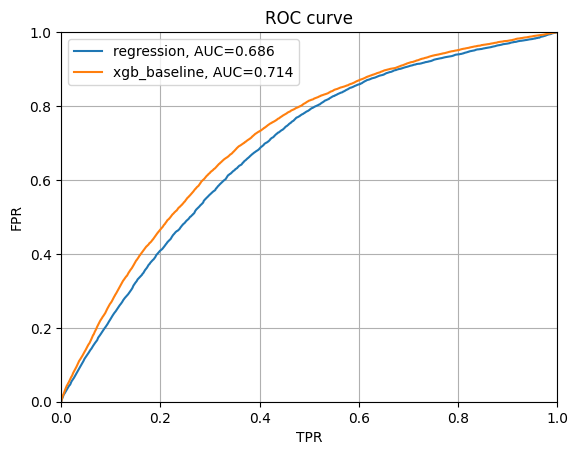

In [140]:
for truth, preds, label in model_results:
    fpr, tpr, _ = roc_curve(truth, preds)
    auc = roc_auc_score(truth, preds)

    plt.plot(fpr, tpr, label=f'{label}, AUC={auc:.3f}')

plt.grid()
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend()
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('ROC curve')
plt.show()

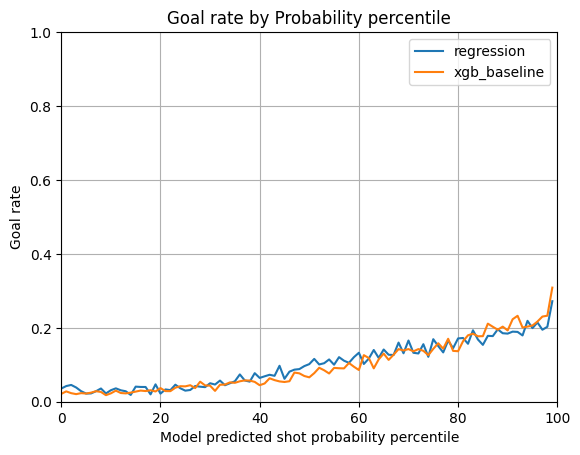

In [141]:
for truth, preds, label in model_results:
    df2 = pd.DataFrame({'probability': preds, 'goal': truth})
    percentiles = pd.qcut(df2['probability'], q=100, duplicates='drop')
    goal_rate = df2.groupby(percentiles).goal.mean()

    plt.plot(list(range(len(percentiles.unique()))), goal_rate, label=label)

plt.ylim((0,1))
plt.xlim((0,100))
plt.xlabel('Model predicted shot probability percentile')
plt.ylabel('Goal rate')
plt.grid()
plt.legend()
plt.title('Goal rate by Probability percentile')
plt.show()

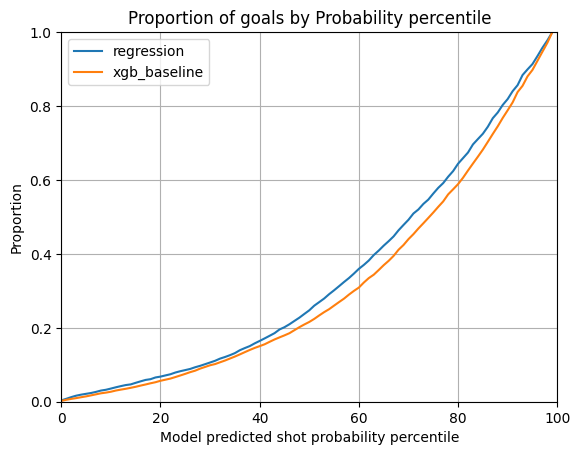

In [142]:
for truth, preds, label in model_results:
    df2 = pd.DataFrame({'probability': preds, 'goal': truth})
    percentiles = pd.qcut(df2['probability'], q=100, duplicates='drop')
    grouped_goals = df2.groupby(percentiles).goal.sum()
    proportion_goals = grouped_goals.cumsum() / grouped_goals.sum()

    plt.plot(list(range(len(percentiles.unique()))), proportion_goals, label=label)

plt.ylim((0,1))
plt.xlim((0,100))
plt.xlabel('Model predicted shot probability percentile')
plt.ylabel('Proportion')
plt.grid()
plt.legend()
plt.title('Proportion of goals by Probability percentile')
plt.show()

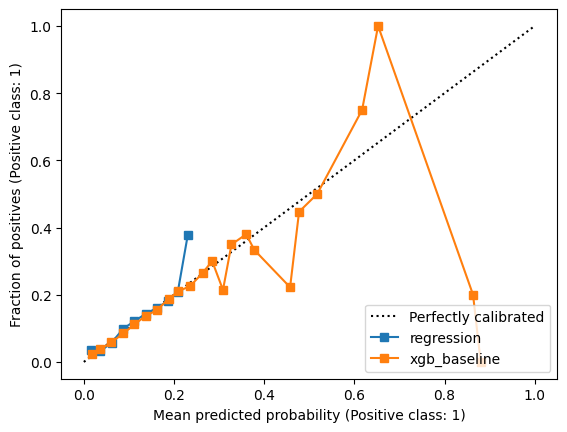

In [143]:
ax = plt.gca()
for truth, preds, label in model_results:
    CalibrationDisplay.from_predictions(truth, preds, ax=ax, n_bins=40, label=label)

**QUESTION 5.2**

In [144]:
feat = [
    'shot_distance', 
    'shot_angle', 
    #'speed', 
    #'angle_change', 
    'rebound', 
    'dist_prev_event', 
    'time_lapsed_prev_event_in_seconds', 
    'game_secs'
]

trans = [
    mirror_coordinates,
    append_shot_angle,
    append_shot_distance,
    replace_nan_by_0,
    append_game_secs,
    append_time_lapse_prev,
    append_dist_prev,
    append_rebound,
    append_angle_change,
    append_speed
]

pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=feat,
    target_column='goal',
    pipeline_steps=[
        ('xgb_model', xgb.XGBClassifier()),
    ],
    dataset_transformations=trans,
    parameter_grid=[{
              'xgb_model__objective':['binary:logistic'],
              #'xgb_model__learning_rate': [0.05, 0.1, 0.15],
              'xgb_model__learning_rate': [0.15],
              #'xgb_model__max_depth': [2, 3, 4],
              'xgb_model__max_depth': [4],
              #'xgb_model__min_child_weight': [0.5, 1, 1.5],
              'xgb_model__min_child_weight': [1],
              'xgb_model__n_estimators': [100],
              }],
    metric='roc_auc',
    enable_comet=False
)


In [145]:
%%time
pipeline.run()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.750 total time=   8.2s
[CV 2/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.747 total time=   8.3s
[CV 3/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.743 total time=   8.7s
[CV 4/5] END xgb_model__learning_rat

In [146]:
accuracy = pipeline.grid.best_score_
f'Best accuracy: {accuracy:.4f}'

'Best accuracy: 0.7453'

In [147]:
x_train, y_train = pipeline.dataset['x_train'], pipeline.dataset['y_train']
x_test, y_test = pipeline.dataset['x_test'], pipeline.dataset['y_test']
best_model = pipeline.grid.best_estimator_

y_pred = best_model.predict(x_test)
model_results.append((y_test.to_numpy().flatten(), best_model.predict_proba(x_test)[:,1], 'xgb_everything'))

res = pd.DataFrame(pipeline.grid.cv_results_)
print('Best model:', best_model)
print(pd.Series(y_pred).value_counts())
print(confusion_matrix(y_test, y_pred))

Best model: Pipeline(steps=[('xgb_model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.15,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_st

<AxesSubplot: xlabel='param_xgb_model__max_depth', ylabel='param_xgb_model__min_child_weight'>

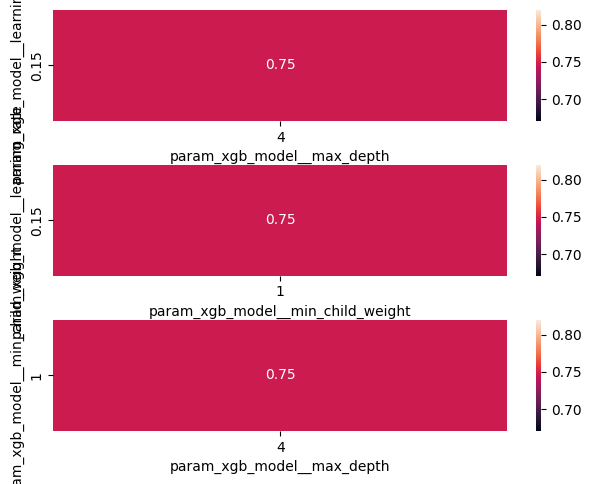

In [148]:
import seaborn as sns

gb = res.groupby(['param_xgb_model__learning_rate', 'param_xgb_model__max_depth', 'param_xgb_model__min_child_weight']).agg({'mean_test_score': 'mean'})

res1 = res.pivot_table(index='param_xgb_model__learning_rate', columns='param_xgb_model__max_depth',
                     values='mean_test_score', aggfunc='mean')

res2 = res.pivot_table(index='param_xgb_model__learning_rate', columns='param_xgb_model__min_child_weight',
                     values='mean_test_score', aggfunc='mean')

res3 = res.pivot_table(index='param_xgb_model__min_child_weight', columns='param_xgb_model__max_depth',
                     values='mean_test_score', aggfunc='mean')

fig, axes = plt.subplots(3)
fig.tight_layout()
sns.heatmap(res1, annot=True, ax=axes[0])
sns.heatmap(res2, annot=True, ax=axes[1])
sns.heatmap(res3, annot=True, ax=axes[2])

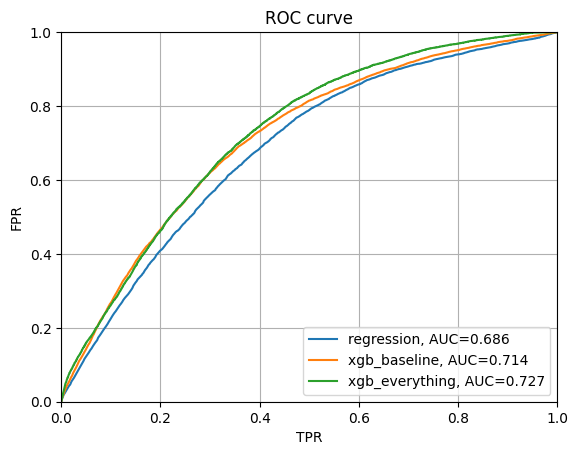

In [149]:
for truth, preds, label in model_results:
    fpr, tpr, _ = roc_curve(truth, preds)
    auc = roc_auc_score(truth, preds)

    plt.plot(fpr, tpr, label=f'{label}, AUC={auc:.3f}')

plt.grid()
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend()
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('ROC curve')
plt.show()

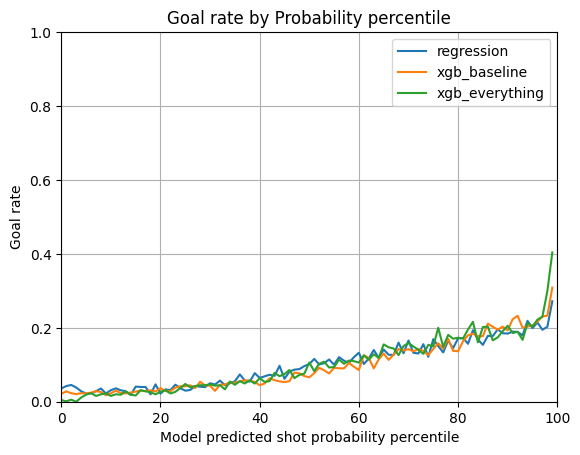

In [150]:
for truth, preds, label in model_results:
    df2 = pd.DataFrame({'probability': preds, 'goal': truth})
    percentiles = pd.qcut(df2['probability'], q=100, duplicates='drop')
    goal_rate = df2.groupby(percentiles).goal.mean()

    plt.plot(list(range(len(percentiles.unique()))), goal_rate, label=label)

plt.ylim((0,1))
plt.xlim((0,100))
plt.xlabel('Model predicted shot probability percentile')
plt.ylabel('Goal rate')
plt.grid()
plt.legend()
plt.title('Goal rate by Probability percentile')
plt.show()

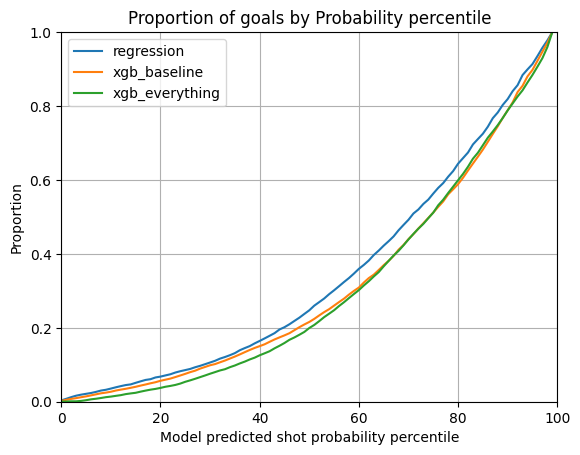

In [151]:
for truth, preds, label in model_results:
    df2 = pd.DataFrame({'probability': preds, 'goal': truth})
    percentiles = pd.qcut(df2['probability'], q=100, duplicates='drop')
    grouped_goals = df2.groupby(percentiles).goal.sum()
    proportion_goals = grouped_goals.cumsum() / grouped_goals.sum()

    plt.plot(list(range(len(percentiles.unique()))), proportion_goals, label=label)

plt.ylim((0,1))
plt.xlim((0,100))
plt.xlabel('Model predicted shot probability percentile')
plt.ylabel('Proportion')
plt.grid()
plt.legend()
plt.title('Proportion of goals by Probability percentile')
plt.show()

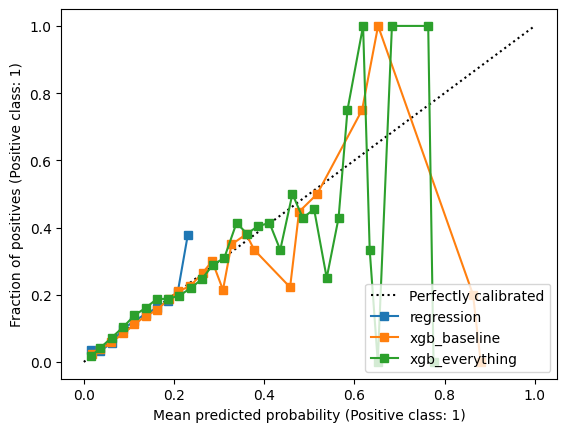

In [152]:
ax = plt.gca()
for truth, preds, label in model_results:
    CalibrationDisplay.from_predictions(truth, preds, ax=ax, n_bins=40, label=label)

**QUESTION 5.3**